# Naive representation

*First pipeline:*
* **1. Data preparation (correlation step):**
    * 1.1 image initialization (spatial domain)
    * 1.2 Fourier transform (frequency domain)
    
    &rarr; simulates radio visibility data
* **2. Data embedding (calibration step):**
    * 2.1 data pre-processing
    * 2.2 data encoding
    
    &rarr; embeds visibilities into qubits
* **3. Data reading (imaging step):**
    * 3.1 readout
    * 3.2 inverse Fourier transform (spatial domain) - IFT
    
    &rarr; approximates science-ready intermediate product  

*Second pipeline:*
* **1. Data preparation (correlation step):**
     * 1.1 image initialization (spatial domain)
     * 1.2 Fourier transform (frequency domain)
     
     &rarr; simulates radio visibility data
* **2. Data embedding (calibration step):**
    * 2.1 data pre-processing
    * 2.2 data encoding
    * 2.3 quantum inverse Fourier transform - QFT
    
    &rarr; embeds visibilities into qubits and applies QFT on qubits
* **3. Data reading (imaging step):**
    * 3.1 readout
    
    &rarr; approximates science-ready intermediate product  

*Digital encoding (binary):*

* circuit family #1 from [Cortese 2018](https://arxiv.org/abs/1803.01958)
* to many features to simulate for PennyLane's implementation - Basis embedding ([Teamplates](https://docs.pennylane.ai/en/stable/introduction/templates.html))

#### Prerequisites

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import struct

import qiskit
from qiskit import *

In [2]:
# float to binary 
def float_to_bin_real(num):
    return format(struct.unpack('!I', struct.pack('!f', num))[0], '032b')
def float_to_bin_imag(num):
    return format(struct.unpack('!I', struct.pack('!f', num))[0], '032b')

# binary to float
def bin_to_float_real(binary):
    return struct.unpack('!f',struct.pack('!I', int(binary, 2)))[0]
def bin_to_float_imag(binary):
    return struct.unpack('!f',struct.pack('!I', int(binary, 2)))[0]

# reverse a string (for the measurement step readout)
def reverse(string):
    string = string[::-1]
    return string

## 1. Data preparation (correlation step)

### 1.1 image initialization (spatial domain)

In [3]:
# image of the sky filled with double precision complex floats (single precision for reals/imaginaries)
# few pixels are set to relatively large complex random values in random spots (image sources)
# relatively small complex values are added (white noise from background radiations) 

n = 10 #number of antennas

sky_image = np.zeros((n, n), dtype='complex64')
mask = np.zeros((n, n), dtype='bool')
stars = np.random.randint(1, 11) #random number of sources
radius = 1 #np.random.randint(1, 3) #with random radius

for i in range(0, stars):
    index_i = np.random.randint(0, sky_image.shape[0]-radius)
    index_j = np.random.randint(0, sky_image.shape[1]-radius)
    for j in range(0, radius):
        for k in range(0, radius):
            sky_image[index_i+j][index_j+k] = complex(np.random.rand()*100, np.random.rand()*100)
            mask[index_i+j][index_j+k] = True
            
sky_image.real += np.random.randn(n,n)/100
sky_image.imag += np.random.randn(n,n)/100

print(sky_image)

[[ 8.5281217e-03-4.1211052e-03j  9.1163591e-03-4.3895035e-03j
   7.3536313e-03-6.2374109e-03j  7.8843534e-03+2.3263510e-02j
   4.8486763e-03-2.3314536e-03j  1.4071392e-03-1.2335697e-02j
   4.3414929e-03+4.6851924e-03j  9.9567940e+01+7.5203781e+01j
   4.3096580e-03+6.3164928e-03j  3.7544670e-03+1.3052221e-02j]
 [ 7.7927583e-03+2.0291477e-02j  1.1277217e-02-4.3847864e-03j
  -4.5368043e-03+2.5360975e-03j  2.0047489e-03+7.8407517e-03j
  -3.9601228e-03+1.0440742e-02j  4.3326193e-03-2.2063479e-02j
   9.1535700e-03+1.1612136e-02j -7.9397559e-03+6.5662214e-03j
   1.3207512e-02-5.2267942e-04j -5.9969770e-03+3.5811338e-04j]
 [ 9.8798787e-03+3.3402147e-03j  8.3248001e-03-7.0324894e-03j
  -1.1925634e-02-3.9729062e-03j -1.8844033e-04-1.7571053e-02j
  -1.6112857e-02+9.5206527e-03j -2.0447848e-02+5.8112964e-03j
   4.8359423e-03+5.5888309e-03j  1.5716300e-03-1.6197404e-02j
  -4.3476992e-03+3.9870087e-05j -3.7378373e-03-5.4312074e-03j]
 [-2.9950855e-02-6.2172883e-03j -8.6678658e-03-5.2104467e-03j
  -6.

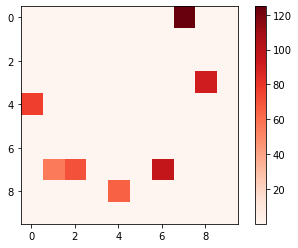

In [4]:
modulus = np.absolute(sky_image)
plt.imshow(modulus, cmap='Reds') 
cbar = plt.colorbar()

### 1.2 Fourier transform (frequency domain)

In [5]:
visibilities = np.fft.fft2(sky_image).astype('complex64')
print(visibilities)

[[ 391.47116  +362.01044j     26.433094  +62.458733j
    39.3238   -190.47824j     97.01429   -76.05238j
   -28.121805  -78.394875j    85.47888  +177.85106j
   124.64247   -45.22381j     47.053333 +139.47754j
  -151.68275   +31.367392j   119.84669  -223.92195j  ]
 [-196.46075   +23.04865j     44.46574   +59.511635j
    -8.758356  +39.73131j     82.00489   -33.016636j
   -25.97868   -80.71841j   -330.34583  -218.42194j
   248.20683  -195.4821j      -2.4574573+188.40381j
  -274.1504    -71.64658j    -50.74353  -281.19565j  ]
 [ -29.452484  -86.6j       -191.214    +158.13644j
  -134.02133  -146.95923j    242.17026  +238.97308j
    25.97709  +422.86133j   -162.22154  -146.82025j
   120.26723   +49.042915j    45.139194  +56.65945j
    58.102512 +143.13115j    106.63925   +74.768715j ]
 [ 411.22772   +93.867256j  -190.31544   +32.67573j
    25.2376   -409.20792j     15.003268 -148.9976j
   -25.931118  +64.86116j    105.66924   -21.432035j
   -50.92776   -19.04073j     98.76406   -58.125847j

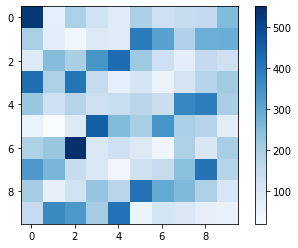

In [6]:
modulus = np.absolute(visibilities)
plt.imshow(modulus, cmap='Blues')
plt.colorbar();

#### * Sanity check

In [7]:
img = np.fft.ifft2(visibilities).astype('complex64')

test_real = ((sky_image.real - img.real)**2).mean()
test_imag = ((sky_image.imag - img.imag)**2).mean()
 
print('Reals MSE: '+ str(test_real))
print('Imaginaries MSE: '+ str(test_imag))

Reals MSE: 1.1772904e-13
Imaginaries MSE: 1.749469e-13


## 2. Data embedding (calibration step)

### 2.1 data pre-processing
### 2.2 data encoding

In [8]:
# encoding binary data onto qubits
def binary_encode(qc, binary, off_set):
    
    for i in range(0, len(binary)):
        qc.reset(off_set+i) # set quantum state |0> by default for all qubits

        if binary[i]=='1':
            qc.x(off_set+i) # act as a CX (controlled X gate)
    
    off_set += len(binary)

    return off_set

In [9]:
number_of_entries = visibilities.shape[0] * visibilities.shape[1]
number_of_bits_real = 32
number_of_bits_imag = 32
number_of_bits = number_of_bits_real + number_of_bits_imag
off_set = 0

# encoding (n bits encoded onto n qubits)
qc = QuantumCircuit(number_of_entries*number_of_bits)
for i in range(0, visibilities.shape[0]):
    for j in range(0, visibilities.shape[1]):
            binary_real = float_to_bin_real(visibilities[i, j].real)
            binary_imag = float_to_bin_imag(visibilities[i, j].imag)
            binary = binary_real+binary_imag
            off_set = binary_encode(qc, binary, off_set)

## 3. Data reading

### 3.1 readout

In [10]:
# measurement
qc.measure_all()
backend = Aer.get_backend('aer_simulator') # Qiskit's staple simulator (CHOICE MOTIVATION?)
job = backend.run(qc, shots=1, memory=True) 
output = job.result().get_memory()[0]
out = reverse(output)

# readout
chunks_real = []
chunks_imag = []
for i in range(0, number_of_entries):
    chunks_real.append(out[number_of_bits*i:(number_of_bits*i)+number_of_bits_real]) # real parts represented every 64 bits starting from the first one
    chunks_imag.append(out[(number_of_bits*i)+number_of_bits_imag:(number_of_bits*i)+number_of_bits_imag+number_of_bits_imag]) # imaginary parts represented every 64 bits starting after the first occurence of a real part 

readout = []
for i in range(0, len(chunks_real)):
    readout.append(complex(bin_to_float_real(chunks_real[i]), bin_to_float_imag(chunks_imag[i]))) 

readout = np.array(readout).reshape(n , n).astype('complex64')
print(readout)

[[ 391.47116  +362.01044j     26.433094  +62.458733j
    39.3238   -190.47824j     97.01429   -76.05238j
   -28.121805  -78.394875j    85.47888  +177.85106j
   124.64247   -45.22381j     47.053333 +139.47754j
  -151.68275   +31.367392j   119.84669  -223.92195j  ]
 [-196.46075   +23.04865j     44.46574   +59.511635j
    -8.758356  +39.73131j     82.00489   -33.016636j
   -25.97868   -80.71841j   -330.34583  -218.42194j
   248.20683  -195.4821j      -2.4574573+188.40381j
  -274.1504    -71.64658j    -50.74353  -281.19565j  ]
 [ -29.452484  -86.6j       -191.214    +158.13644j
  -134.02133  -146.95923j    242.17026  +238.97308j
    25.97709  +422.86133j   -162.22154  -146.82025j
   120.26723   +49.042915j    45.139194  +56.65945j
    58.102512 +143.13115j    106.63925   +74.768715j ]
 [ 411.22772   +93.867256j  -190.31544   +32.67573j
    25.2376   -409.20792j     15.003268 -148.9976j
   -25.931118  +64.86116j    105.66924   -21.432035j
   -50.92776   -19.04073j     98.76406   -58.125847j

### 3.2 inverse Fourier transform (spatial domain)

In [11]:
img = np.fft.ifft2(readout).astype('complex64')

#### fidelity test

In [12]:
test_real = ((sky_image.real - img.real)**2).mean()
test_imag = ((sky_image.imag - img.imag)**2).mean()

print('Reals MSE: '+ str(test_real))
print('Imaginaries MSE: '+ str(test_imag))

Reals MSE: 1.1772904e-13
Imaginaries MSE: 1.749469e-13


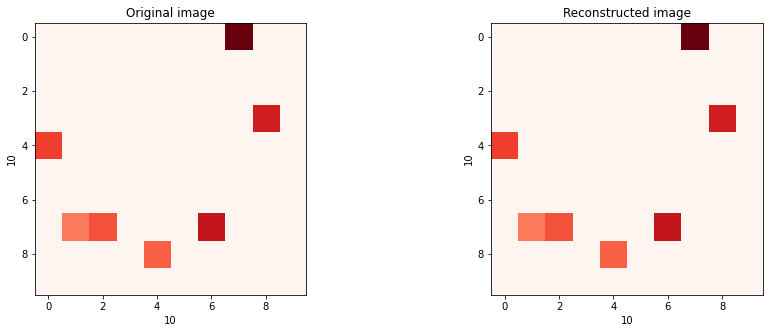

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
modulus1 = np.absolute(sky_image)
modulus2 = np.absolute(img)

axs[0].imshow(modulus1, cmap='Reds')
axs[1].imshow(modulus2, cmap='Reds')

axs[0].set_title("Original image")
axs[1].set_title("Reconstructed image")

for ax in axs.flat:
    ax.set(xlabel=n, ylabel=n)